In [1]:
import pandas as pd

# Initial Processing
- Partially doing this as a remembering exercise
- Partially as a restructuring

In [2]:
raw = pd.read_csv('../Data/Raw/E0_1718.csv')

In [3]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 65 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Div       380 non-null    object 
 1   Date      380 non-null    object 
 2   HomeTeam  380 non-null    object 
 3   AwayTeam  380 non-null    object 
 4   FTHG      380 non-null    int64  
 5   FTAG      380 non-null    int64  
 6   FTR       380 non-null    object 
 7   HTHG      380 non-null    int64  
 8   HTAG      380 non-null    int64  
 9   HTR       380 non-null    object 
 10  Referee   380 non-null    object 
 11  HS        380 non-null    int64  
 12  AS        380 non-null    int64  
 13  HST       380 non-null    int64  
 14  AST       380 non-null    int64  
 15  HF        380 non-null    int64  
 16  AF        380 non-null    int64  
 17  HC        380 non-null    int64  
 18  AC        380 non-null    int64  
 19  HY        380 non-null    int64  
 20  AY        380 non-null    int64 

## Column clean up
- Chop off all betting information for now
    - Will come to this later g

In [4]:
raw = raw.loc[:, :'AR']

In [5]:
raw.drop(columns=['Div','Referee', 'HTHG', 'HTAG', 'HTR'], inplace = True)
raw['Date'] = pd.to_datetime(raw['Date'], format='%d/%m/%y')

- Set aside fixture/result information

In [6]:
results = raw.loc[:, ['Date', 'HomeTeam', 'AwayTeam', 'FTR']]

## Creating Features
- Need to be able to summarise information at various different timescales and use that to be able to generate features
- Need summarised by home - away and all together

### Splitting into home and away

In [7]:
raw.columns

Index(['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HS', 'AS',
       'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR'],
      dtype='object')

In [8]:
homeCols = ['Date', 'HomeTeam', 'FTHG', 'FTAG', 'FTR', 'HS', 'AS',
       'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR']

awayCols = ['Date', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HS', 'AS',
       'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR']

In [9]:
def createColMap(cols, is_home):
    if is_home:
        map = {"H": "_f", "A": "_ag"}
        teamCol = "HomeTeam"
    else:
        map = {"H": "_ag", "A": "_f"}
        teamCol = "AwayTeam"
    
    
    newCols = []
    for col in cols:
        index = 0
        if col in ["Date", "HomeTeam", "AwayTeam", "FTR"]:
            if col == teamCol:
                newCols.append("Team")
            else:
                newCols.append(col)
            continue
        else:
            if col[0] == "F":
                index = 2
            newCols.append(col[index + 1:] + map[col[index]])

    return dict(zip(cols, newCols))

homeColMap = createColMap(homeCols, True)
awayColMap = createColMap(awayCols, False)
                
                
    

In [10]:
homeColMap

{'Date': 'Date',
 'HomeTeam': 'Team',
 'FTHG': 'G_f',
 'FTAG': 'G_ag',
 'FTR': 'FTR',
 'HS': 'S_f',
 'AS': 'S_ag',
 'HST': 'ST_f',
 'AST': 'ST_ag',
 'HF': 'F_f',
 'AF': 'F_ag',
 'HC': 'C_f',
 'AC': 'C_ag',
 'HY': 'Y_f',
 'AY': 'Y_ag',
 'HR': 'R_f',
 'AR': 'R_ag'}

In [11]:
awayColMap

{'Date': 'Date',
 'AwayTeam': 'Team',
 'FTHG': 'G_ag',
 'FTAG': 'G_f',
 'FTR': 'FTR',
 'HS': 'S_ag',
 'AS': 'S_f',
 'HST': 'ST_ag',
 'AST': 'ST_f',
 'HF': 'F_ag',
 'AF': 'F_f',
 'HC': 'C_ag',
 'AC': 'C_f',
 'HY': 'Y_ag',
 'AY': 'Y_f',
 'HR': 'R_ag',
 'AR': 'R_f'}

In [12]:
home = raw[homeCols].copy().rename(columns=homeColMap)
away = raw[awayCols].copy().rename(columns=awayColMap)


In [13]:
home.head()

,Date,Team,G_f,G_ag,FTR,S_f,S_ag,ST_f,ST_ag,F_f,F_ag,C_f,C_ag,Y_f,Y_ag,R_f,R_ag
0,2017-08-11,Arsenal,4,3,H,27,6,10,3,9,12,9,4,0,1,0,0
1,2017-08-12,Brighton,0,2,A,6,14,2,4,6,9,3,10,0,2,0,0
2,2017-08-12,Chelsea,2,3,A,19,10,6,5,16,11,8,5,3,3,2,0
3,2017-08-12,Crystal Palace,0,3,A,14,8,4,6,7,19,12,9,1,3,0,0
4,2017-08-12,Everton,1,0,H,9,9,4,1,13,10,6,7,1,1,0,0


In [14]:
away.head()

,Date,Team,G_ag,G_f,FTR,S_ag,S_f,ST_ag,ST_f,F_ag,F_f,C_ag,C_f,Y_ag,Y_f,R_ag,R_f
0,2017-08-11,Leicester,4,3,H,27,6,10,3,9,12,9,4,0,1,0,0
1,2017-08-12,Man City,0,2,A,6,14,2,4,6,9,3,10,0,2,0,0
2,2017-08-12,Burnley,2,3,A,19,10,6,5,16,11,8,5,3,3,2,0
3,2017-08-12,Huddersfield,0,3,A,14,8,4,6,7,19,12,9,1,3,0,0
4,2017-08-12,Stoke,1,0,H,9,9,4,1,13,10,6,7,1,1,0,0


### Create wdl columns

In [15]:
def createWDLCols(df, at_home):
    results = ["H", "D", "A"]
    if not at_home:
        if 'HomeTeam' in df.columns:
            print("Check if away, 'HomeTeam' column present")
            return 0
        results.reverse()
    elif 'AwayTeam' in df.columns:
        print("Check if home, 'AwayTeam' column present")
        return 0
    labels = ["Win", "Draw", "Loss"]
    for result, label in zip(results, labels):
        df[label] = (df["FTR"] == result).astype(int)

In [16]:
createWDLCols(home, True)

In [17]:
home.head()

,Date,Team,G_f,G_ag,FTR,S_f,S_ag,ST_f,ST_ag,F_f,F_ag,C_f,C_ag,Y_f,Y_ag,R_f,R_ag,Win,Draw,Loss
0,2017-08-11,Arsenal,4,3,H,27,6,10,3,9,12,9,4,0,1,0,0,1,0,0
1,2017-08-12,Brighton,0,2,A,6,14,2,4,6,9,3,10,0,2,0,0,0,0,1
2,2017-08-12,Chelsea,2,3,A,19,10,6,5,16,11,8,5,3,3,2,0,0,0,1
3,2017-08-12,Crystal Palace,0,3,A,14,8,4,6,7,19,12,9,1,3,0,0,0,0,1
4,2017-08-12,Everton,1,0,H,9,9,4,1,13,10,6,7,1,1,0,0,1,0,0


In [18]:
createWDLCols(away, False)

In [19]:
away.head()

,Date,Team,G_ag,G_f,FTR,S_ag,S_f,ST_ag,ST_f,F_ag,F_f,C_ag,C_f,Y_ag,Y_f,R_ag,R_f,Win,Draw,Loss
0,2017-08-11,Leicester,4,3,H,27,6,10,3,9,12,9,4,0,1,0,0,0,0,1
1,2017-08-12,Man City,0,2,A,6,14,2,4,6,9,3,10,0,2,0,0,1,0,0
2,2017-08-12,Burnley,2,3,A,19,10,6,5,16,11,8,5,3,3,2,0,1,0,0
3,2017-08-12,Huddersfield,0,3,A,14,8,4,6,7,19,12,9,1,3,0,0,1,0,0
4,2017-08-12,Stoke,1,0,H,9,9,4,1,13,10,6,7,1,1,0,0,0,0,1


In [20]:
home.drop(columns="FTR", inplace=True)
away.drop(columns="FTR", inplace=True)

### Combine home and away

In [21]:
home_tmp = home.copy()
away_tmp = away.copy()

In [22]:
comb = pd.concat([home_tmp, away_tmp], ignore_index=True, copy=True)

In [23]:
comb.head()

,Date,Team,G_f,G_ag,S_f,S_ag,ST_f,ST_ag,F_f,F_ag,C_f,C_ag,Y_f,Y_ag,R_f,R_ag,Win,Draw,Loss
0,2017-08-11,Arsenal,4,3,27,6,10,3,9,12,9,4,0,1,0,0,1,0,0
1,2017-08-12,Brighton,0,2,6,14,2,4,6,9,3,10,0,2,0,0,0,0,1
2,2017-08-12,Chelsea,2,3,19,10,6,5,16,11,8,5,3,3,2,0,0,0,1
3,2017-08-12,Crystal Palace,0,3,14,8,4,6,7,19,12,9,1,3,0,0,0,0,1
4,2017-08-12,Everton,1,0,9,9,4,1,13,10,6,7,1,1,0,0,1,0,0


#### TODO: Add home and away also into combined

### PTs column

In [24]:
def createPtsColumn(df):
    df['Pts'] = df['Win'] * 3  + df['Draw']

In [25]:
createPtsColumn(comb)

In [26]:
comb.head()

,Date,Team,G_f,G_ag,S_f,S_ag,ST_f,ST_ag,F_f,F_ag,C_f,C_ag,Y_f,Y_ag,R_f,R_ag,Win,Draw,Loss,Pts
0,2017-08-11,Arsenal,4,3,27,6,10,3,9,12,9,4,0,1,0,0,1,0,0,3
1,2017-08-12,Brighton,0,2,6,14,2,4,6,9,3,10,0,2,0,0,0,0,1,0
2,2017-08-12,Chelsea,2,3,19,10,6,5,16,11,8,5,3,3,2,0,0,0,1,0
3,2017-08-12,Crystal Palace,0,3,14,8,4,6,7,19,12,9,1,3,0,0,0,0,1,0
4,2017-08-12,Everton,1,0,9,9,4,1,13,10,6,7,1,1,0,0,1,0,0,3


### Get Season information to date
- Calculate aggregate stats for upto and including given date 

In [27]:
comb = comb.sort_values(['Team', 'Date'], ascending=[True, True]).reset_index(drop=True)
comb.head()

,Date,Team,G_f,G_ag,S_f,S_ag,ST_f,ST_ag,F_f,F_ag,C_f,C_ag,Y_f,Y_ag,R_f,R_ag,Win,Draw,Loss,Pts
0,2017-08-11,Arsenal,4,3,27,6,10,3,9,12,9,4,0,1,0,0,1,0,0,3
1,2017-08-19,Arsenal,0,1,18,11,6,4,11,6,9,2,0,0,0,0,0,0,1,0
2,2017-08-27,Arsenal,0,4,8,18,0,10,9,6,3,4,4,2,0,0,0,0,1,0
3,2017-09-09,Arsenal,3,0,15,6,8,1,14,8,8,2,0,1,0,0,1,0,0,3
4,2017-09-17,Arsenal,0,0,11,13,2,4,15,11,1,5,3,1,0,1,0,1,0,1


In [28]:
comb['Played'] = 1
stdFull = comb.groupby(["Team", "Date"]).sum().groupby(level=0).cumsum().reset_index()

In [29]:
stdFull.head()

,Team,Date,G_f,G_ag,S_f,S_ag,ST_f,ST_ag,F_f,F_ag,...,C_ag,Y_f,Y_ag,R_f,R_ag,Win,Draw,Loss,Pts,Played
0,Arsenal,2017-08-11,4,3,27,6,10,3,9,12,...,4,0,1,0,0,1,0,0,3,1
1,Arsenal,2017-08-19,4,4,45,17,16,7,20,18,...,6,0,1,0,0,1,0,1,3,2
2,Arsenal,2017-08-27,4,8,53,35,16,17,29,24,...,10,4,3,0,0,1,0,2,3,3
3,Arsenal,2017-09-09,7,8,68,41,24,18,43,32,...,12,4,4,0,0,2,0,2,6,4
4,Arsenal,2017-09-17,7,8,79,54,26,22,58,43,...,17,7,5,0,1,2,1,2,7,5


#### Scope how to get features attached to fixtures

In [30]:
stdFull['join_Date'] = stdFull[['Team', 'Date']].sort_values(['Team', 'Date']).groupby('Team').shift(-1)

In [31]:
l_join_keys = [['HomeTeam', 'Date'], ['AwayTeam', 'Date']]
r_pres = ['STD_H_', 'STD_A_']
tmp = results.copy()
info = list(results.columns)
join_keys = []
for keys, r_pre in zip(l_join_keys, r_pres):
    r_join_keys = [r_pre + key for key in ['Team', 'join_Date']]
    tmp = tmp.merge(stdFull.add_prefix(r_pre),
                    how='left',
                    left_on=keys,
                    right_on=r_join_keys).drop(columns=r_join_keys)
    join_keys.append(r_pre + 'Date')
features = list((set(tmp.columns) - set(info)) - set(join_keys))

In [32]:
info

['Date', 'HomeTeam', 'AwayTeam', 'FTR']

In [33]:
tmp[['HomeTeam', 'AwayTeam','STD_H_Pts', 'STD_A_Pts']].tail()

,HomeTeam,AwayTeam,STD_H_Pts,STD_A_Pts
375,Newcastle,Chelsea,41.0,70.0
376,Southampton,Man City,36.0,97.0
377,Swansea,Stoke,33.0,30.0
378,Tottenham,Leicester,74.0,47.0
379,West Ham,Everton,39.0,49.0


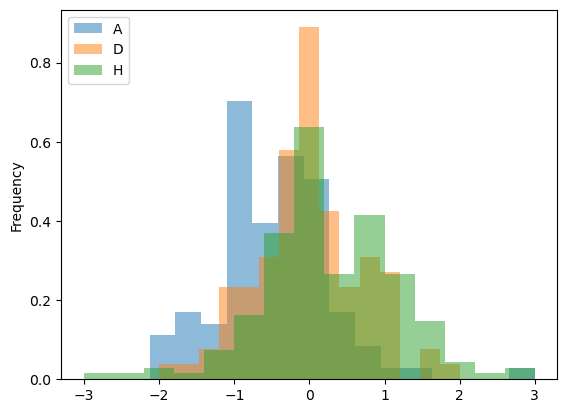

In [34]:
import matplotlib.pyplot as plt
ind_map = {'H':'r', 'D':'g', 'A':'b'}
tmp['ind'] = tmp['FTR'].apply(lambda x: ind_map[x])
tmp['STD_Pts_Diff_Avg'] = (tmp['STD_H_Pts'] / tmp['STD_H_Played']) - (tmp['STD_A_Pts'] / tmp['STD_A_Played'])
tmp[['FTR', 'STD_Pts_Diff_Avg']].groupby('FTR')['STD_Pts_Diff_Avg'].plot.hist(alpha=0.5, density=True, bins=15)
plt.legend(loc='upper left')

FTR
A    Axes(0.125,0.11;0.775x0.77)
D    Axes(0.125,0.11;0.775x0.77)
H    Axes(0.125,0.11;0.775x0.77)
Name: STD_H_Pts, dtype: object

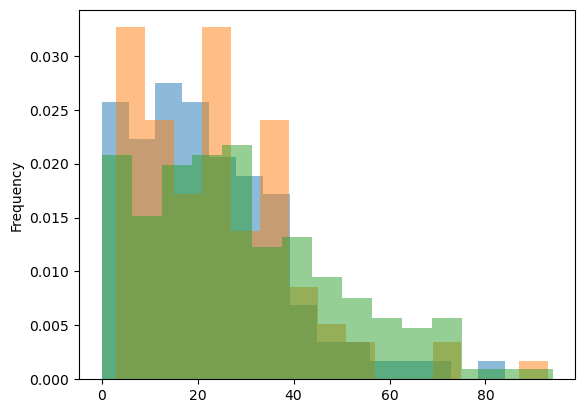

In [35]:
tmp[['FTR', 'STD_H_Pts']].groupby('FTR')['STD_H_Pts'].plot.hist(alpha=0.5, density=True, bins=15)

<Axes: xlabel='STD_Pts_Diff_Avg', ylabel='STD_H_Pts'>

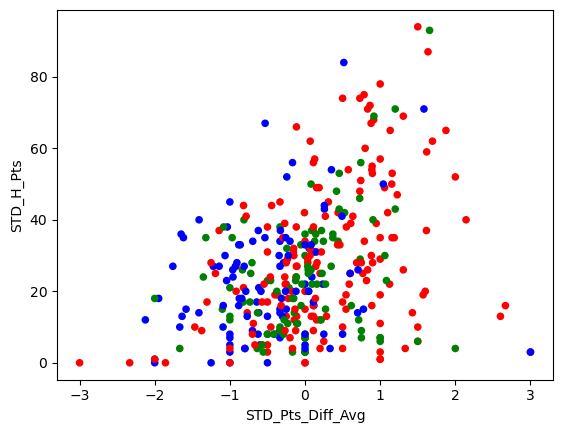

In [36]:
tmp.plot.scatter('STD_Pts_Diff_Avg', 'STD_H_Pts', c='ind')

In [37]:
tmp['STD_Pts_Diff_Avg']

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
375   -0.783784
376   -1.648649
377    0.081081
378    0.729730
379   -0.270270
Name: STD_Pts_Diff_Avg, Length: 380, dtype: float64

### Find out how to calculate form 

In [38]:
comb.groupby(["Team"]).rolling(window=2, on='Date').sum()

Date  C_ag   C_f  Draw  F_ag   F_f  G_ag  G_f  Loss  \
Team                                                                     
Arsenal  0   2017-08-11   NaN   NaN   NaN   NaN   NaN   NaN  NaN   NaN   
         1   2017-08-19   6.0  18.0   0.0  18.0  20.0   4.0  4.0   1.0   
         2   2017-08-27   6.0  12.0   0.0  12.0  20.0   5.0  0.0   2.0   
         3   2017-09-09   6.0  11.0   0.0  14.0  23.0   4.0  3.0   1.0   
         4   2017-09-17   7.0   9.0   1.0  19.0  29.0   0.0  3.0   0.0   
...                 ...   ...   ...   ...   ...   ...   ...  ...   ...   
West Ham 755 2018-04-22   9.0  16.0   1.0  32.0  24.0   5.0  2.0   1.0   
         756 2018-04-29  15.0   6.0   0.0  22.0  14.0   8.0  2.0   2.0   
         757 2018-05-05  15.0   3.0   0.0  19.0  14.0   4.0  3.0   1.0   
         758 2018-05-10  14.0   4.0   1.0  20.0  21.0   0.0  2.0   0.0   
         759 2018-05-13  12.0   7.0   1.0  25.0  22.0   1.0  3.0   0.0   

              Played  Pts  R_ag  R_f  ST_ag  ST_f  S_ag   S_f  Win  Y_ag  Y_f  
Team                                                                           
Arsenal  0       NaN  NaN   NaN  NaN    NaN   NaN   NaN   NaN  NaN   NaN  NaN  
         1       2.0  3.0   0.0  0.0    7.0  16.0  17.0  45.0  1.0   1.0  0.0  
         2       2.0  0.0   0.0  0.0   14.0   6.0  29.0  26.0  0.0   2.0  4.0  
         3       2.0  3.0   0.0  0.0   11.0   8.0  24.0  23.0  1.0   3.0  4.0  
         4       2.0  4.0   1.0  0.0    5.0  10.0  19.0  26.0  1.0   2.0  3.0  
...              ...  ...   ...  ...    ...   ...   ...   ...  ...   ...  ...  
West Ham 755     2.0  1.0   0.0  0.0   15.0  10.0  31.0  29.0  0.0   6.0  4.0  
         756     2.0  0.0   0.0  0.0   15.0   5.0  39.0  15.0  0.0   4.0  2.0  
         757     2.0  3.0   0.0  0.0    9.0   4.0  32.0  17.0  1.0   2.0  2.0  
         758     2.0  4.0   0.0  0.0    8.0   5.0  29.0  22.0  1.0   2.0  3.0  
         759     2.0  4.0   0.0  0.0   13.0   6.0  30.0  24.0  1.0   2.0  1.0  

[760 rows x 20 columns]